<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#KCUSUM-examples-(linear-statistic)" data-toc-modified-id="KCUSUM-examples-(linear-statistic)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>KCUSUM examples (linear statistic)</a></span></li><li><span><a href="#Processing-the-different-CUSUM-plots" data-toc-modified-id="Processing-the-different-CUSUM-plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Processing the different CUSUM plots</a></span></li><li><span><a href="#Experiments-with-KSPRT-(full-statistic)" data-toc-modified-id="Experiments-with-KSPRT-(full-statistic)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiments with KSPRT (full statistic)</a></span></li><li><span><a href="#Verifying-the-C++-implementation-of-KSPRT" data-toc-modified-id="Verifying-the-C++-implementation-of-KSPRT-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Verifying the C++ implementation of KSPRT</a></span></li><li><span><a href="#*-Everything-below-here-is-plotting-of-external-results-*" data-toc-modified-id="*-Everything-below-here-is-plotting-of-external-results-*-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>* Everything below here is plotting of external results *</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Good-result-with-non-linear-statistic" data-toc-modified-id="Good-result-with-non-linear-statistic-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Good result with non-linear statistic</a></span></li></ul></li></ul></li><li><span><a href="#Low-variance-estimator-vs-simple-to-implement-estimator" data-toc-modified-id="Low-variance-estimator-vs-simple-to-implement-estimator-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Low variance estimator vs simple-to-implement estimator</a></span></li><li><span><a href="#Paper-change-in-mean" data-toc-modified-id="Paper-change-in-mean-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Paper change in mean</a></span></li><li><span><a href="#Paper-change-in-var" data-toc-modified-id="Paper-change-in-var-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Paper change in var</a></span></li></ul></div>

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import izip

plt.rcParams["figure.figsize"]  = 7, 5
def fst(lst): return [ele[0] for ele in lst ];
def snd(lst): return [ele[1] for ele in lst ];

# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
import matplotlib as mpl
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  

mpl.rc('font', **{'size'   : 18})
plt.rc('text', usetex=True)
mpl.rcParams['lines.linewidth'] = 3.0


In [39]:
change_settings_1 = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 0.5,
                    'cdim' : 4,
                    'cudelta' : 2.00**(-7),
                    'ctype' : 1 }

change_settings_2 = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 0, 
                    'sigma2' : 2,
                    'cdim': 4,
                    'cudelta' :  2.00**(-7),
                    'ctype' : 2}

change_settings_3 = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 2,
                    'cdim': 4,
                    'cudelta' :  2.00**(-7),
                    'ctype' : 3}

change_settings_4 = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 2,
                    'cdim': 4,
                    'cudelta' :  2.00**(-9),
                    'ctype' : 4}

In [40]:
def k(x,y,alpha=2,sigma2=2): #alpha=1: Laplace kernel. alpha=2: Gaussian
    #return pow(np.linalg.norm(x),alpha) + pow(np.linalg.norm(y),alpha) - pow(np.linalg.norm(x-y),alpha)
    return np.exp(-pow(np.linalg.norm(x-y),alpha)/sigma2)

In [41]:
def h(x1,  #obs 1
      y1,  # ref 1
      x2,  # obs 2
      y2): # ref 2  
    return k(x1, x2) + k(y1, y2) - k(x1, y2) - k(x2, y1) #See p. 729 in "a kernel two sample test"

In [42]:
def refgen(change_settings):
    return change_settings['sigma1']*np.random.randn(change_settings['cdim']) + change_settings['mu1']

In [43]:
def kcusum_generator(seq,
                     nref,
                     cudelta,
                     change_settings): #cudelta is what u subtract dude
    #print("kcusum_generator: cudelta %f" % cudelta)
    z = 0.
    x_prev = 0
    n = 0
    for x in seq:
        if n%2 == 1:
            hval = 0.
            for i in range(nref):
                hval += h(x_prev,refgen(change_settings),x,refgen(change_settings))
            gn = hval/nref - cudelta
            z = max(0, z + gn)
        x_prev = x
        yield z

In [44]:
def ksprt_generator(seq,nref=50,cudelta=0.0): #seq is the incoming observations
    
    allref = []
    allx = []
    z = 0
    
    for x in seq:
        ref = refgen()
     
        for (xprev,refprev) in zip(allx,allref): #compare with all previous observation and references
            z += h(xprev,refprev,x,ref) 
     
        m = len(allx)
        
        allref.append(ref)    
        allx.append(x)
        
        #print("Z is %f "% z)
        if z < 0:
            allref = []
            allx = []
            z = 0          
        
        ret = 0
        if m > 0:
            ret = z/m;
         
        yield ret

In [45]:
# Function to generate a random sequence.
# The sequence may or may not have a change point,
# (mu1,sigma1) are the distribution parameters before the change,
# (mu2,sigma2) are the parameters after the change.
def sequence_generator(length, 
                       change_settings,
                       seed = None,
                       change_point = None): #ret[change_point] = 1st new pt 

    ctype = change_settings['ctype']
    
    cdim = change_settings['cdim']
    
    mu1 = change_settings['mu1']
    sigma1 = change_settings['sigma1']
    mu2 = change_settings['mu2']
    sigma2 = change_settings['sigma2']
    
    if seed is None: 
        seed =  random.randrange(2**32 - 1)
        
    np.random.seed(seed)
    #print("Seed was:", seed)
    
    if change_point == None: change_point = length
    i=0;
    while i < length:
        if i < change_point:
             nextpt = sigma1*np.random.randn(cdim) 
        else:
            if ctype == 1:  # change in mean 
                nextpt = sigma1*np.random.randn(cdim) + mu2 
            elif ctype == 2: # change in variance
                nextpt = sigma2*np.random.randn(cdim) + mu1
            elif ctype == 3: # change in variance in random component
                nextpt = sigma1*np.random.randn(cdim) 
                idx = np.random.randint(cdim)
                nextpt[idx] = sigma2*np.random.randn() 
                nextpt = nextpt + mu1
            elif ctype==4: # change to uniform uniform with same variance
                nextpt = (2*np.random.rand(cdim) - 1)*np.sqrt(3)*sigma1 
            elif ctype==5: # random component becomes uniform
                nextpt = sigma1*np.random.randn(cdim)
                idx = np.random.randint(cdim)
                nextpt[idx] = (2*np.random.rand() - 1)*np.sqrt(3)*sigma1 
        i = i + 1
        yield nextpt
        

In [46]:
def detect_time(seq,h,startpt=0): #returns the detected time (possibly infty) and ** an empty sequence ** 
    i = 0
    the_seq = []
    for x in seq:
        #the_seq.append(x)
        if x >= h and i >= startpt:
            return (i,the_seq)
        i = i + 1
    return (np.infty, the_seq)

# KCUSUM examples (linear statistic)

In [119]:
vis_change_settings = {}
vis_change_settings[1] = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 0.5,
                    'cdim' : 4,
                    'cudelta' : 2.00**(-7),
                    'ctype' : 1 }

vis_change_settings[2] = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 0, 
                    'sigma2' : 1,
                    'cdim': 4,
                    'cudelta' :  2.00**(-7),
                    'ctype' : 2}

vis_change_settings[3] = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 1,
                    'cdim': 4,
                    'cudelta' :  2.00**(-7),
                    'ctype' : 3}

vis_change_settings[4] = { 'mu1' : 0,
                    'sigma1' : 0.5,
                    'mu2' : 1, 
                    'sigma2' : 2,
                    'cdim': 4,
                    'cudelta' :  2.00**(-9),
                    'ctype' : 4}

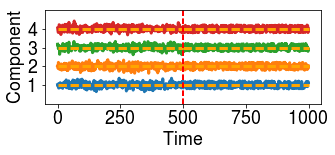

In [135]:
cpt = 500
length = 1000
plt.rcParams['figure.figsize'] = 5, 2.5
idx = 4
a_seq = list( sequence_generator(length =length,change_point = cpt,change_settings=vis_change_settings[idx])) # signal|
#plt.title("Sequence")
plt.xlabel("Time")
plt.ylabel("Component")

a_seq = np.array(a_seq)
for i in range(4):
    dy=i*4
    plt.plot( a_seq[:,i]+ dy );  #Note: This results in multiple plots  when a_seq is multidimensional
    plt.plot((0,cpt),(dy,dy),'--',color='orange',); #oranee horizontal line at 0 to change point
    plt.plot((cpt,length),(dy,dy),'--',color='orange'); #orange horizontal line from change point to end
plt.yticks([0,4,8,12],[1,2,3,4])
plt.ylim(ymin=-4,ymax=16)
plt.axvline(cpt,color='r', linewidth=2,linestyle='--') #vertical line right at the change point
plt.tight_layout()
plt.savefig("multi_ex_%d.pdf" % idx)

In [112]:
cpt = 500
length = 3000
a_seq = list( sequence_generator(length =length,change_point = cpt,change_settings=change_settings)) # signal|
plt.title("Sequence")
plt.plot( a_seq );  #Note: This results in multiple plots  when a_seq is multidimensional
plt.plot((0,cpt),(0,0),'--',color='orange',); #oranee horizontal line at 0 to change point
plt.plot((cpt,length),(0,0),'--',color='orange'); #orange horizontal line from change point to end
plt.axvline(cpt,color='g', linewidth=1,linestyle='--') #vertical line right at the change point
plt.figure()
cudelta = change_settings['cudelta'] #2.00**(-6)
thresh = 7
for i in range(1):
    cz = list( kcusum_generator(a_seq,nref=40,cudelta=cudelta,change_settings=change_settings) );
    dt = detect_time(cz,thresh)[0]
    print("Cu delta = %f => Detection @ %f" % (cudelta,dt))
    print("Cz mean: %f (pre) %f (post) " % (np.mean(cz[0:500]), np.mean(cz[500:])))
    plt.plot( cz, label= ("%f" % cudelta ) ); plt.axvline(cpt,color='g', linewidth=1,linestyle='--');  plt.axvline(dt,color='r', linewidth=1,linestyle='--'),plt.title("CUSUM");
    cudelta /= 2.
    
plt.ylim(ymin=np.min(cz))
#plt.title("Change point at %s" % str("infty" if cpt is None else cpt))
plt.legend()

NameError: name 'change_settings' is not defined

In [47]:
#Estimate the TTFA and Worst-case delay

def estimate_ttfa(hval,change_settings,runs=200):
    delta = change_settings['cudelta']
    fatimes = []
    #print("delta is %f h is %f" % (delta,hval))
    for i in range(runs):
        a_seq = sequence_generator(length = np.infty,change_point = np.infty,change_settings=change_settings) # signal|
        cz =  kcusum_generator(a_seq,nref=10,cudelta=delta,change_settings=change_settings)
        dt = detect_time(cz,hval)[0]
        #print("( h = %f , delta = %f ) => Detection @ %f" % (hval,delta,dt))
        fatimes.append(dt)
    m,v = np.mean(fatimes), np.var(fatimes)
    print("ttfa @ h = %f with %d runs: mean %f var %f" %(hval, runs,m,v ))
    return m



    #plt.plot( cz, label= ("%f" % cudelta ) ); plt.axvline(cpt,color='g', linewidth=1,linestyle='--');  plt.axvline(dt,color='r', linewidth=1,linestyle='--'),plt.title("CUSUM");
    #plt.title("Change point at %s" % str(("infty" if cpt is None else cpt)))
    #plt.legend()

In [12]:
estimate_ttfa(hval=1,change_settings=change_settings)

NameError: name 'change_settings' is not defined

In [48]:
def estimate_delay(hval,change_settings,runs=500):
    delta = change_settings['cudelta']
    delaytimes = []
    #print("delta is %f h is %f" % (delta,hval))
    for i in range(runs):
       # print(delta)
        a_seq = sequence_generator(length = np.infty,change_point = 0,change_settings=change_settings) # signal|
        cz =  kcusum_generator(a_seq,nref=10,cudelta=change_settings['cudelta'],change_settings=change_settings)
        dt = detect_time(cz,hval)[0]
        #print("( h = %f , delta = %f ) => Detection @ %f" % (hval,delta,dt))
        delaytimes.append(dt)
    m,v = np.mean(delaytimes), np.var(delaytimes)
    print("delay @ h = %f with %d runs: mean %f var %f" %(hval, runs,m,v) )
    return m

In [14]:
estimate_delay(hval=3,change_settings=change_settings)

NameError: name 'change_settings' is not defined

In [49]:
def get_data_point(hval, change_settings):
    t = estimate_ttfa( hval = hval, change_settings = change_settings, runs = 1000)
    d = estimate_delay( hval = hval, change_settings = change_settings, runs = 5000)
    return (t,d)

In [18]:
def generate_parametric(change_settings):
    hval = 0.1
    t,d = get_data_point(hval,change_settings)
    data = [(t,d,hval)]

    while t < 1000:
        hval *= 2
        t,d = get_data_point(hval,change_settings)
        data.append( (t,d,hval) )

    data.sort(key=lambda x: x[0])

    biggap = True

    while biggap:
        print("Data is now %s" % str(data))
        biggap = False
        for i in range(len(data)-1):
            if data[i+1][0] - data[i][0] > 100:
                if data[i][0] > 1000: continue
                biggap = True
                hval = (data[i+1][2] + data[i][2])/2.
                t,d = get_data_point(hval,change_settings)
                data.append( (t,d,hval) ) #format = ( ttfa, delay, threshold)
                data.sort(key=lambda x: x[0])
                break

    np.save("data_%d.txt" % change_settings['ctype'], data)
    return data

In [19]:
data = generate_parametric(change_settings=change_settings_3)

KeyboardInterrupt: 

Text(0.5,1,'KCUSUM performance')

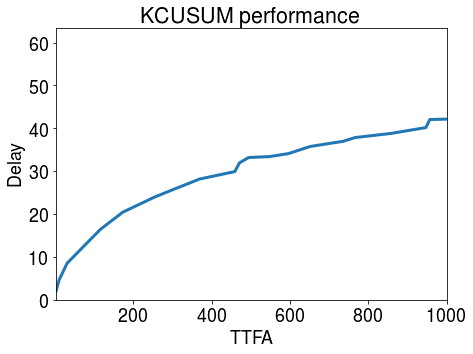

In [155]:
ts = [ d[0] for d in data]
ds = [ d[1] for d in data]

plt.plot(ts,ds,'-')
plt.xlabel("TTFA")
plt.ylabel("Delay")
plt.xlim(xmin=min(ts),xmax=1000)#max(ts))
plt.ylim(ymin=0,ymax=max(ds))
plt.title("KCUSUM performance")

# Processing the different CUSUM plots

28
[0.0, 3.111111111111111, 6.222222222222222, 9.333333333333334, 12.444444444444445, 15.555555555555555, 18.666666666666668, 21.77777777777778, 24.88888888888889, 28.0]
26
[0.0, 2.888888888888889, 5.777777777777778, 8.666666666666666, 11.555555555555555, 14.444444444444445, 17.333333333333332, 20.22222222222222, 23.11111111111111, 26.0]
17
[0.0, 1.8888888888888888, 3.7777777777777777, 5.666666666666666, 7.555555555555555, 9.444444444444445, 11.333333333333332, 13.222222222222221, 15.11111111111111, 17.0]
3
[0.0, 0.3333333333333333, 0.6666666666666666, 1.0, 1.3333333333333333, 1.6666666666666665, 2.0, 2.333333333333333, 2.6666666666666665, 3.0]


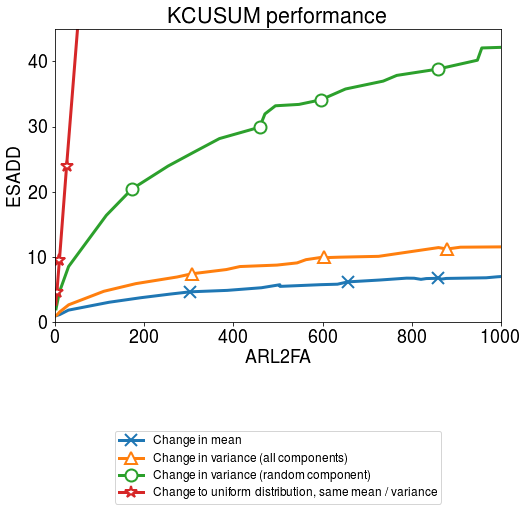

In [37]:


markers = ['x', '^', 'o', '*']
names = ['Change in mean',
        'Change in variance (all components)',
        'Change in variance (random component)',
        'Change to uniform distribution, same mean / variance']


#plt.rcParams["figure.figsize"] =(10,4)
plt.rcParams["figure.figsize"] =(8,6)

for i in [1,2,3,4]:
    marklist = list([ int(x) for x in np.linspace(1,1000,5)])
    marklist[-1] -= 1
    
    data = np.load("data_%d.txt.npy" % i)
    ts = [ d[0] for d in data]
    ds = [ d[1] for d in data]
    mx = max( filter(lambda x: ds[x]<40, range(len(ts))))
    print(mx)
    print(list(np.linspace(0,mx,10)))
    plt.plot(ts,
             ds,
             marker = markers[i-1],
             markevery=[int (x) for x in np.linspace(1,mx,5)][1:],
             markersize = 12,
             markerfacecolor='w',
             markeredgewidth=2,
             label = names[i-1])
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

#on the side
#ax.legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#         ncol=1,title="Type of change")

#below
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
          ncol=1,
          fontsize=12,
          #title="Type of change"
         )
plt.xlabel("ARL2FA")
plt.ylabel("ESADD")
plt.ylim(ymin=0,ymax=45)
plt.xlim(xmin=0,xmax=1000) #max(ts))
plt.title("KCUSUM performance")

#plt.tight_layout()
plt.savefig("empirical_performance.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

Text(0.5,1,'KCUSUM - Problem 3 performance')

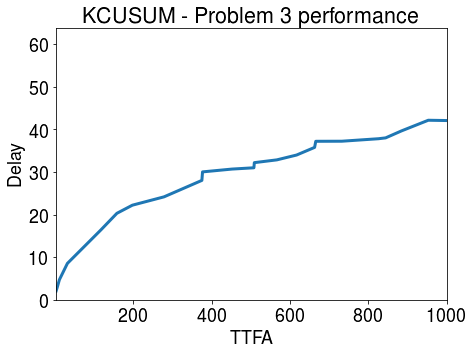

In [142]:
plt.plot(ts,ds)
plt.xlabel("TTFA")
plt.ylabel("Delay")
plt.xlim(xmin=min(ts),xmax=1000)#max(ts))
plt.ylim(ymin=0,ymax=max(ds))
plt.title("KCUSUM - Problem 3 performance")


In [140]:
d = estimate_delay( hval = 2.8, change_settings = change_settings_3, runs = 1000) #2.8 -> 27.5, 3.0 -> 29.8

delay mean 28.032000 var 167.012976


Text(0.5,1,'KCUSUM - Problem 2 performance')

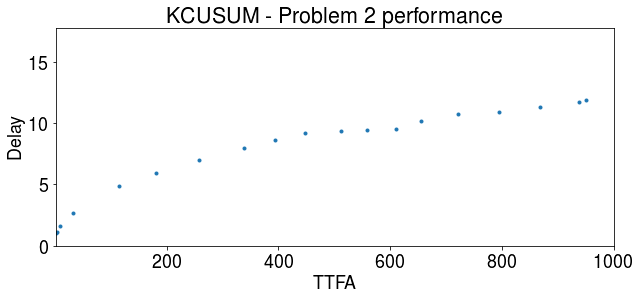

In [808]:
ts = [ d[0] for d in data2]
ds = [ d[1] for d in data2]

plt.plot(ts,ds,'.')
plt.xlabel("TTFA")
plt.ylabel("Delay")
plt.xlim(xmin=min(ts),xmax=1000)#max(ts))
plt.ylim(ymin=0,ymax=max(ds))
plt.title("KCUSUM - Problem 2 performance")

Text(0.5,1,'KCUSUM - Problem 1 performance')

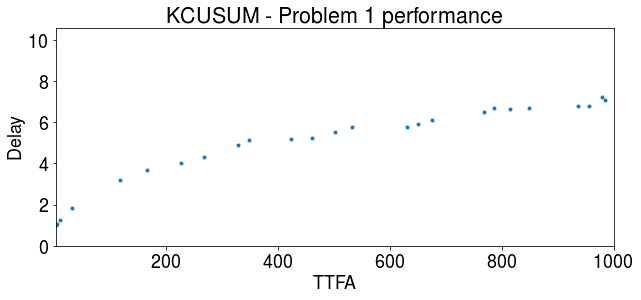

In [803]:
ts = [ d[0] for d in data1]
ds = [ d[1] for d in data1]

plt.plot(ts,ds,'.')
plt.xlabel("TTFA")
plt.ylabel("Delay")
plt.xlim(xmin=min(ts),xmax=1000) #max(ts))
plt.ylim(ymin=0,ymax=max(ds))
plt.title("KCUSUM - Problem 1 performance")

In [761]:
ts = []
ds = []
for hval in [0.1,0.5,1.0,1.5,1.75,2.0,2.1,2.2,2.3,2.4,2.45,2.5,2.6,2.65,2.8,3]:
    t = estimate_ttfa(delta=change_settings['cudelta'],hval=hval,change_settings=change_settings)
    ts.append(t)
    d = estimate_delay(delta=change_settings['cudelta'],hval=hval,change_settings=change_settings)
    ds.append(d)
    print("at h = %f time-to-false-alarm is %f delay is %f" % (hval,t,d))

mean 2.675000 var 8.469375
mean 2.708000 var 6.378736
at h = 0.100000 time-to-false-alarm is 2.675000 delay is 2.708000
mean 14.830000 var 175.201100
mean 12.960000 var 125.298400
at h = 0.500000 time-to-false-alarm is 14.830000 delay is 12.960000
mean 39.515000 var 1390.319775
mean 34.602000 var 857.519596
at h = 1.000000 time-to-false-alarm is 39.515000 delay is 34.602000
mean 83.655000 var 5543.065975
mean 72.928000 var 3829.454816
at h = 1.500000 time-to-false-alarm is 83.655000 delay is 72.928000
mean 111.635000 var 8337.071775
mean 89.094000 var 5342.937164
at h = 1.750000 time-to-false-alarm is 111.635000 delay is 89.094000
mean 135.000000 var 12152.440000
mean 112.940000 var 9484.996400
at h = 2.000000 time-to-false-alarm is 135.000000 delay is 112.940000
mean 140.490000 var 14240.329900
mean 128.530000 var 11464.329100
at h = 2.100000 time-to-false-alarm is 140.490000 delay is 128.530000
mean 166.340000 var 22991.914400
mean 139.054000 var 12374.363084
at h = 2.200000 time-to-

Text(0.5,1,'KCUSUM performance')

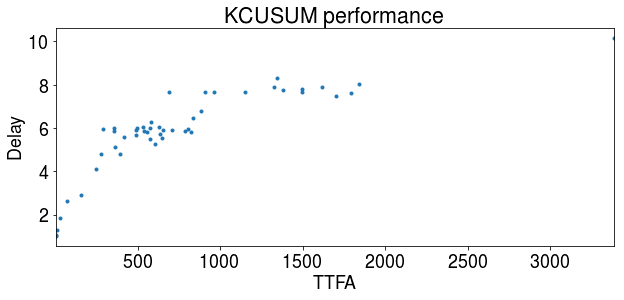

In [792]:
plt.plot(ts,ds,'.')
plt.xlabel("TTFA")
plt.ylabel("Delay")
plt.xlim(xmin=min(ts),xmax=max(ts))
plt.title("KCUSUM performance")

# Experiments with KSPRT (full statistic)

Cu delta = 0.001953 => Detection @ 143.000000


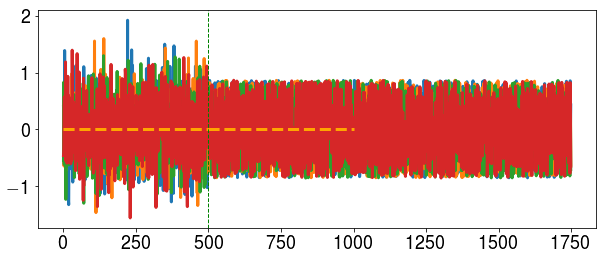

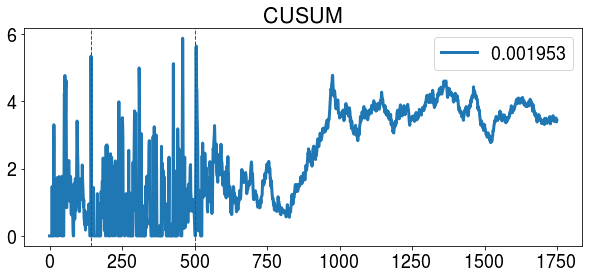

In [554]:
a_seq = list( sequence_generator(length = 1750,change_point = 500)) # signal|
plt.plot( a_seq ); plt.plot((0,cpt),(0,0),'--',color='orange',); plt.plot((cpt,1000),(0,0),'--',color='orange');plt.axvline(cpt,color='g', linewidth=1,linestyle='--')
plt.figure()
cudelta = 2.00**(-9)
for i in range(1):
    cz = list( ksprt_generator(a_seq,cudelta=cudelta) );
    dt = detect_time(cz,5)[0]
    print("Cu delta = %f => Detection @ %f" % (cudelta,dt))
    plt.plot( cz, label= ("%f" % cudelta ) ); plt.axvline(cpt,color='g', linewidth=1,linestyle='--');  plt.axvline(dt,color='r', linewidth=1,linestyle='--'),plt.title("CUSUM");
    cudelta /= 2
    if i == 3: cudelta = 0

plt.legend()

# Verifying the C++ implementation of KSPRT

C++ => Detection @ 613.000000
Cu delta = 0.000488 => Detection @ 96.000000


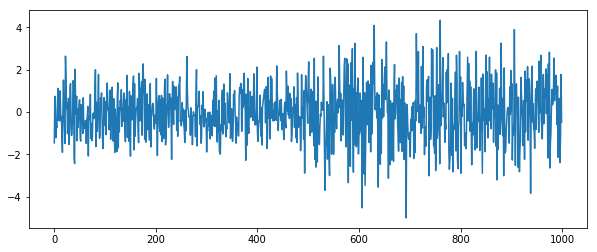

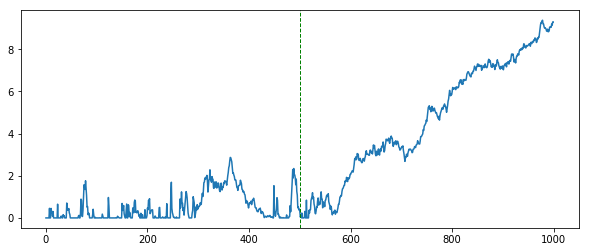

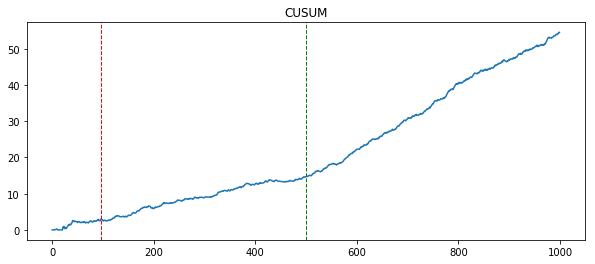

In [59]:
k_seq  = np.loadtxt("k_seq.csv")
k_stat = np.loadtxt("k_stat.csv")
plt.plot(k_seq)
plt.figure()

plt.plot(k_stat)
plt.axvline(cpt,color='g', linewidth=1,linestyle='--')
dt = detect_time(k_stat,3)[0]
print("C++ => Detection @ %f" % (dt))

plt.figure()
cz = list( ksprt_generator(k_seq,cudelta=cudelta) );
dt = detect_time(cz,3)[0]
print("Cu delta = %f => Detection @ %f" % (cudelta,dt))
plt.plot( cz, label= ("%f" % cudelta ) ); 
plt.axvline(cpt,color='g', linewidth=1,linestyle='--');  plt.axvline(dt,color='r', linewidth=1,linestyle='--'),plt.title("CUSUM");

# *** Everything below here is plotting of external results ***

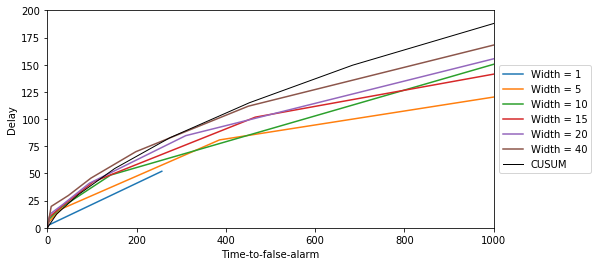

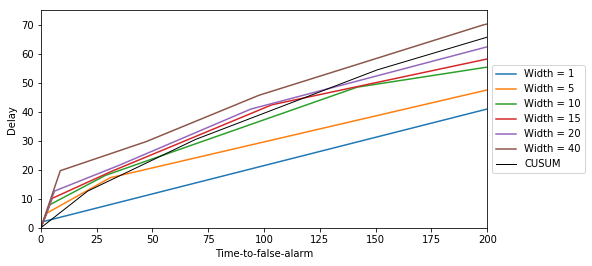

In [14]:
w1 = np.loadtxt("change_in_std/w1.csv",delimiter=',')[:,[1,2]]
w5 = np.loadtxt("change_in_std/w5.csv",delimiter=',')[:,[1,2]]
w10 = np.loadtxt("change_in_std/w10.csv",delimiter=',')[:,[1,2]]
w15 = np.loadtxt("change_in_std/w15.csv",delimiter=',')[:,[1,2]]
w20 = np.loadtxt("change_in_std/w20.csv",delimiter=',')[:,[1,2]]
w40 = np.loadtxt("change_in_std/w40.csv",delimiter=',')[:,[1,2]]
wc = np.loadtxt("change_in_std/c.csv",delimiter=',')[:,[1,2]]


#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
    plt.plot( fst(w5), snd(w5), label = "Width = 5" );
    plt.plot( fst(w10), snd(w10), label = "Width = 10" );
    plt.plot( fst(w15), snd(w15), label = "Width = 15" );
    plt.plot( fst(w20), snd(w20), label = "Width = 20" );
    plt.plot( fst(w40), snd(w40), label = "Width = 40" );
    plt.plot( fst(wc), snd(wc), label = "CUSUM" , color='black', linewidth=1);
    
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0,ymax = 200)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=75)
plt.xlim(xmin =0 ,xmax=200);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

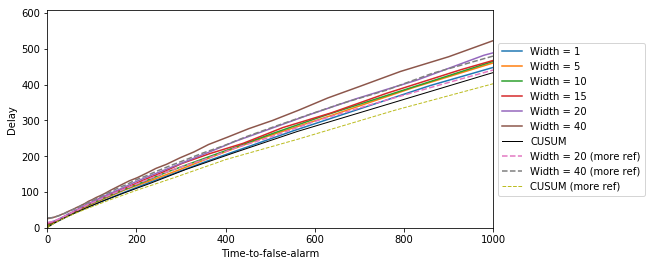

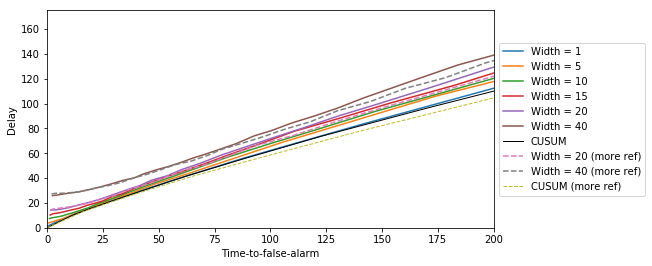

In [15]:
w1 = np.loadtxt("small_change_in_std/w1.csv",delimiter=',')[:,[1,2]]
w5 = np.loadtxt("small_change_in_std/w5.csv",delimiter=',')[:,[1,2]]
w10 = np.loadtxt("small_change_in_std/w10.csv",delimiter=',')[:,[1,2]]
w15 = np.loadtxt("small_change_in_std/w15.csv",delimiter=',')[:,[1,2]]
w20 = np.loadtxt("small_change_in_std/w20.csv",delimiter=',')[:,[1,2]]
w40 = np.loadtxt("small_change_in_std/w40.csv",delimiter=',')[:,[1,2]]
wc = np.loadtxt("small_change_in_std/c.csv",delimiter=',')[:,[1,2]]

wr20 = np.loadtxt("small_change_in_std_more_ref/w20.csv",delimiter=',')[:,[1,2]]
wr40 = np.loadtxt("small_change_in_std_more_ref/w40.csv",delimiter=',')[:,[1,2]]
wrc = np.loadtxt("small_change_in_std_more_ref/c.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
    plt.plot( fst(w5), snd(w5), label = "Width = 5" );
    plt.plot( fst(w10), snd(w10), label = "Width = 10" );
    plt.plot( fst(w15), snd(w15), label = "Width = 15" );
    plt.plot( fst(w20), snd(w20), label = "Width = 20" );
    plt.plot( fst(w40), snd(w40), label = "Width = 40" );
    plt.plot( fst(wc), snd(wc), label = "CUSUM" , color='black', linewidth=1);
    
    plt.plot( fst(wr20), snd(wr20), label = "Width = 20 (more ref)",linestyle ='--' );
    plt.plot( fst(wr40), snd(wr40), label = "Width = 40 (more ref)",linestyle ='--' );
    plt.plot( fst(wrc), snd(wrc), label = "CUSUM (more ref)" ,  linewidth=1, linestyle ='--');
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=175)
plt.xlim(xmin =0 ,xmax=200);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

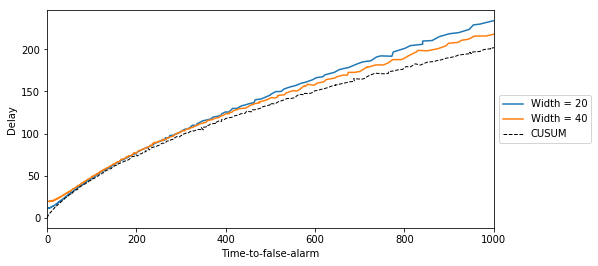

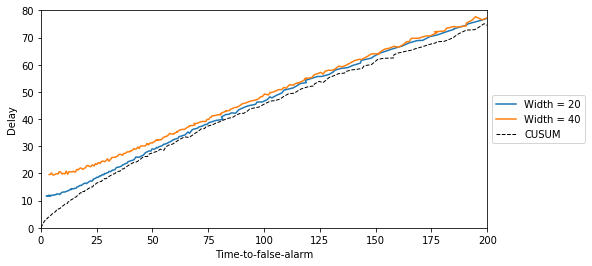

In [16]:
#w1 = np.loadtxt("change_in_mean_non_gauss/w1.csv",delimiter=',')[:,[1,2]]
#w5 = np.loadtxt("change_in_mean_non_gauss/w5.csv",delimiter=',')[:,[1,2]]
#w10 = np.loadtxt("change_in_mean_non_gauss/w10.csv",delimiter=',')[:,[1,2]]
#w15 = np.loadtxt("change_in_mean_non_gauss/w15.csv",delimiter=',')[:,[1,2]]
w20 = np.loadtxt("change_in_mean_non_gauss/w20.csv",delimiter=',')[:,[1,2]]
w40 = np.loadtxt("change_in_mean_non_gauss/w40.csv",delimiter=',')[:,[1,2]]
wc = np.loadtxt("change_in_mean_non_gauss/c.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
 #   plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
 #   plt.plot( fst(w5), snd(w5), label = "Width = 5" );
 #   plt.plot( fst(w10), snd(w10), label = "Width = 10" );
 #   plt.plot( fst(w15), snd(w15), label = "Width = 15" );
    plt.plot( fst(w20), snd(w20), label = "Width = 20" );
    plt.plot( fst(w40), snd(w40), label = "Width = 40" );
    plt.plot( fst(wc), snd(wc), label = "CUSUM" , color='black', linewidth=1, linestyle ='--');
    
      
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

#plt.ylim(ymin=0,ymax = 150)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=80)
plt.xlim(xmin =0 ,xmax=200);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

In [17]:
wc1 = np.loadtxt("change_in_std_gaussian/c0.1.csv",delimiter=',')[:,[1,2]]
wc2 = np.loadtxt("change_in_std_gaussian/c0.2csv",delimiter=',')[:,[1,2]]
wc4 = np.loadtxt("change_in_std_gaussian/c0.4csv",delimiter=',')[:,[1,2]]
wc10 = np.loadtxt("change_in_std_gaussian/c1csv",delimiter=',')[:,[1,2]]

m10 = np.loadtxt("../M_statistic_code/online/change_in_std/m10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/change_in_std/m20.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/change_in_std/m40.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(wc1), snd(wc1), label = "CUSUM 0.1" , linewidth=1);
    plt.plot( fst(wc2), snd(wc2), label = "CUSUM 0.2" , linewidth=1);
    plt.plot( fst(wc4), snd(wc4), label = "CUSUM 0.4" , linewidth=1);
    plt.plot( fst(wc10), snd(wc10), label = "CUSUM 1.0" , linewidth=1);
 
    plt.plot( fst(m10), snd(m10), '--', label = "M Stat. Width = 10" );
    plt.plot( fst(m20), snd(m20), '--', label = "M Stat. Width = 20" );
    plt.plot( fst(m40), snd(m40), '--', label = "M Stat. Width = 40" );
    
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0,ymax = 150)
plt.xlim(xmin = 0, xmax=1000);
plt.title("CUSUM vs M-Stat")
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=75)
plt.xlim(xmin =0 ,xmax=200);

plt.title("CUSUM vs M-Stat (up to T-T-F-A=200)")
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

IOError: change_in_std_gaussian/c0.1.csv not found.

### Good result with non-linear statistic

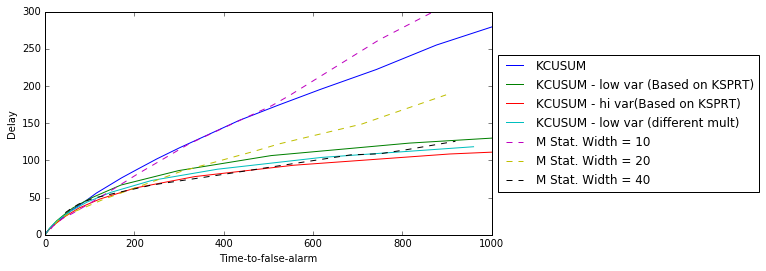

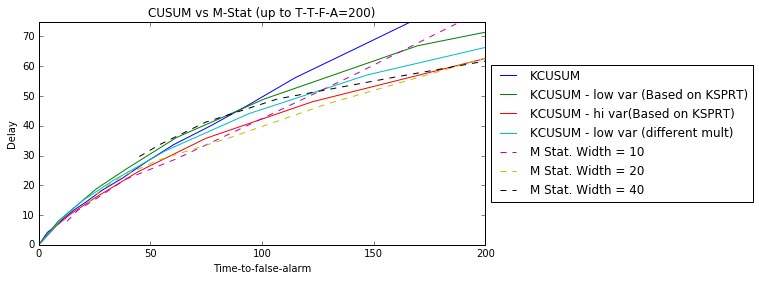

In [38]:

wc1 = np.loadtxt("change_in_std_gaussian/c.csv",delimiter=',')[:,[1,2]]
wc2 = np.loadtxt("change_in_std_gaussian/k.csv",delimiter=',')[:,[1,2]]
wc3 = np.loadtxt("change_in_std_gaussian/k_simpler.csv",delimiter=',')[:,[1,2]]
wc4 = np.loadtxt("change_in_std_gaussian/k_lo.csv",delimiter=',')[:,[1,2]]

m10 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m20.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m40.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(wc1), snd(wc1), label = "KCUSUM" , linewidth=1);
    plt.plot( fst(wc2), snd(wc2), label = "KCUSUM - low var (Based on KSPRT)" , linewidth=1);
    plt.plot( fst(wc3), snd(wc3), label = "KCUSUM - hi var(Based on KSPRT)" , linewidth=1);
    plt.plot( fst(wc4), snd(wc4), label = "KCUSUM - low var (different mult)" , linewidth=1);
     
    plt.plot( fst(m10), snd(m10), '--', label = "M Stat. Width = 10" );
    plt.plot( fst(m20), snd(m20), '--', label = "M Stat. Width = 20" );
    plt.plot( fst(m40), snd(m40), '--', label = "M Stat. Width = 40" );
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0,ymax = 300)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=75)
plt.xlim(xmin =0 ,xmax=200);

plt.title("CUSUM vs M-Stat (up to T-T-F-A=200)")
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

# Low variance estimator vs simple-to-implement estimator


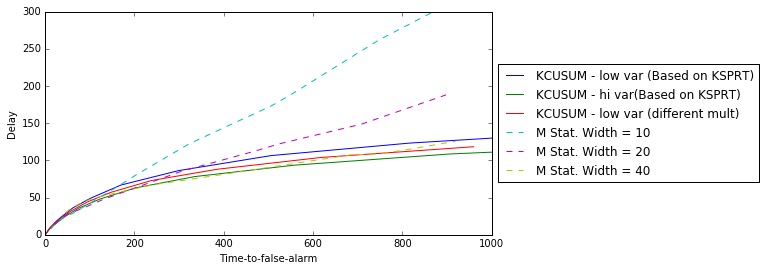

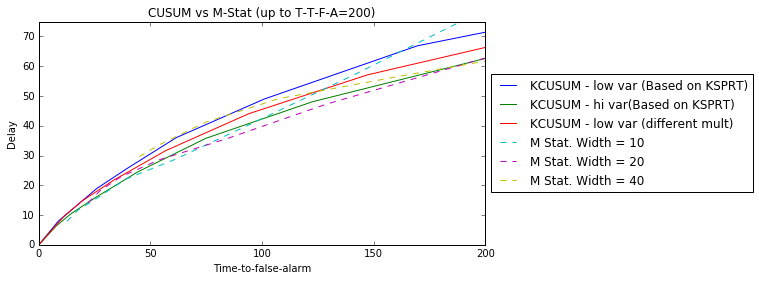

In [46]:

wc2 = np.loadtxt("change_in_std_gaussian/k.csv",delimiter=',')[:,[1,2]]  #These are two variations of the low-var
wc4 = np.loadtxt("change_in_std_gaussian/k_lo.csv",delimiter=',')[:,[1,2]]  #statistic. One has a factor of m on the statistic at time m
#the other has a factor of m-1.

wc3 = np.loadtxt("change_in_std_gaussian/k_simpler.csv",delimiter=',')[:,[1,2]] #This is the simple statistic.

m10 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m20.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m40.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(wc2), snd(wc2), label = "KCUSUM - low var (Based on KSPRT)" , linewidth=1);
    plt.plot( fst(wc3), snd(wc3), label = "KCUSUM - hi var(Based on KSPRT)" , linewidth=1);
    plt.plot( fst(wc4), snd(wc4), label = "KCUSUM - low var (different mult)" , linewidth=1);
     
    plt.plot( fst(m10), snd(m10), '--', label = "M Stat. Width = 10" );
    plt.plot( fst(m20), snd(m20), '--', label = "M Stat. Width = 20" );
    plt.plot( fst(m40), snd(m40), '--', label = "M Stat. Width = 40" );
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0,ymax = 300)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=75)
plt.xlim(xmin =0 ,xmax=200);

plt.title("CUSUM vs M-Stat (up to T-T-F-A=200)")
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

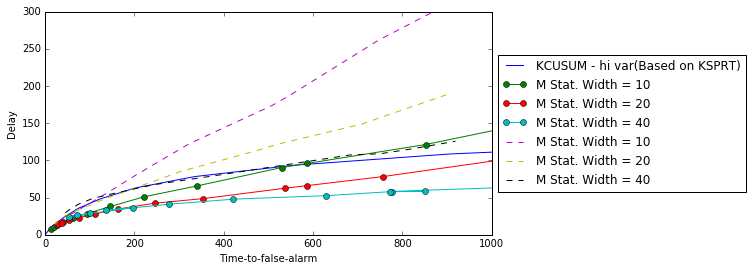

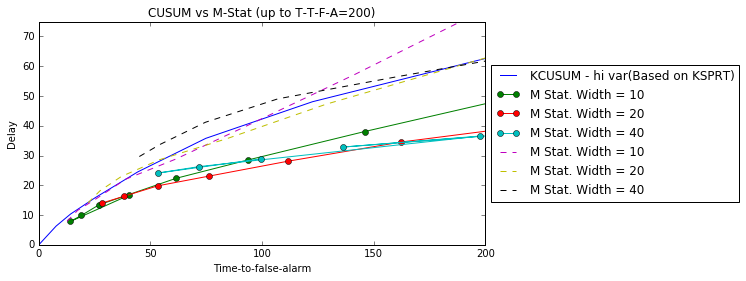

In [45]:
mr10 = np.loadtxt("../M_statistic_code/online/change_in_std/m10.csv",delimiter=',')[:,[1,2]]
mr20 = np.loadtxt("../M_statistic_code/online/change_in_std/m20.csv",delimiter=',')[:,[1,2]]
mr40 = np.loadtxt("../M_statistic_code/online/change_in_std/m40.csv",delimiter=',')[:,[1,2]]

wc3 = np.loadtxt("change_in_std_gaussian/k_simpler.csv",delimiter=',')[:,[1,2]]


m10 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m20.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/change_in_std_ref1/m40.csv",delimiter=',')[:,[1,2]]

#plt.plot( fst(w1), snd(w1), label = "Width = 1" ); 
def do_plots():
    plt.plot( fst(wc3), snd(wc3), label = "KCUSUM - hi var(Based on KSPRT)" , linewidth=1);
     
        
    plt.plot( fst(mr10), snd(mr10), '-o', label = "M Stat. Width = 10" );
    plt.plot( fst(mr20), snd(mr20), '-o', label = "M Stat. Width = 20" );
    plt.plot( fst(mr40), snd(mr40), '-o', label = "M Stat. Width = 40" );
    
    plt.plot( fst(m10), snd(m10), '--', label = "M Stat. Width = 10" );
    plt.plot( fst(m20), snd(m20), '--', label = "M Stat. Width = 20" );
    plt.plot( fst(m40), snd(m40), '--', label = "M Stat. Width = 40" );
    
plt.rcParams["figure.figsize"] =(10,4)
do_plots()

plt.ylim(ymin=0,ymax = 300)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=75)
plt.xlim(xmin =0 ,xmax=200);

plt.title("CUSUM vs M-Stat (up to T-T-F-A=200)")
plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));

# Paper change in mean

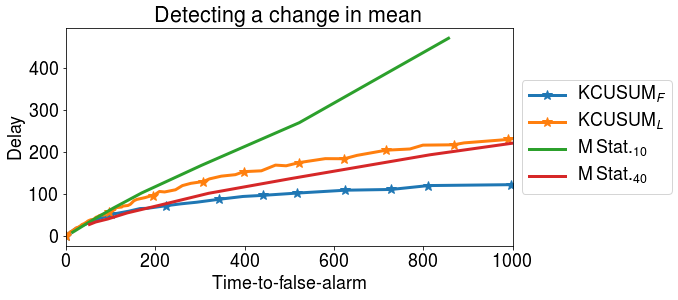

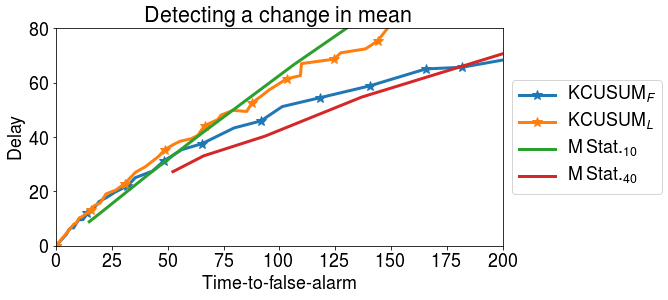

In [24]:

k10 = np.loadtxt("change_in_mean/k10s_3.csv",delimiter=',')[:,[1,2]]
klo10 = np.loadtxt("change_in_mean/klo10s_1.csv",delimiter=',')[:,[1,2]]
w10 = np.loadtxt("change_in_mean/w10s_2.csv",delimiter=',')[:,[1,2]]


m10 = np.loadtxt("../M_statistic_code/online/1/m_10_10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/1/m_20_10.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/1/m_40_10.csv",delimiter=',')[:,[1,2]]
mpl.rc('font', **{'size'   : 18})
plt.rc('text', usetex=True)
mpl.rcParams['lines.linewidth'] = 3.0
def do_plots():

    plt.plot( fst(k10), snd(k10),'-*',markersize=10, markevery=0.1,label = "$ \mathrm{KCUSUM}_{F} $" );
    plt.plot( fst(klo10), snd(klo10),'-*', markersize=10,markevery=0.1,label = "$ \mathrm{KCUSUM}_{L}$" );
    #plt.plot( fst(w10), snd(w10), label = "KWINDOW" , color='black', linewidth=1, linestyle ='--');
    plt.plot( fst(m10), snd(m10), label = "$ \mathrm{M\,Stat.}_{10} $" );
    #plt.plot( fst(m20), snd(m20), label = "m20" );
    plt.plot( fst(m40), snd(m40), label = "$ \mathrm{M\, Stat.}_{40} $" );
    
      
plt.rcParams["figure.figsize"] =(10,4)
do_plots()
#plt.ylim(ymin=0,ymax = 150)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
plt.title("Detecting a change in mean")

# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig("change-in-mean-1000.pdf")


plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=80)
plt.xlim(xmin =0 ,xmax=200);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
plt.title("Detecting a change in mean")
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));
plt.savefig("change-in-mean-200.pdf")


# Paper change in var

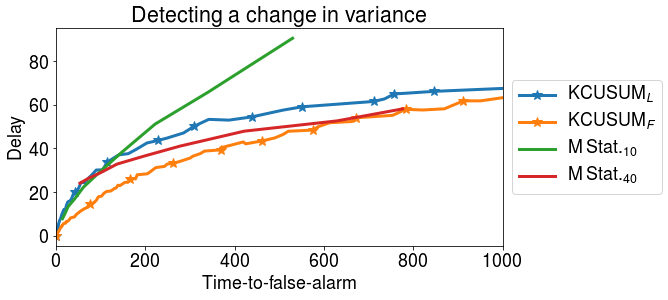

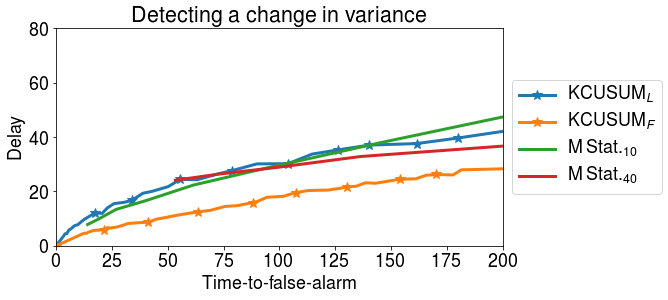

In [25]:
k10 = np.loadtxt("change_in_std/k10s_3.csv",delimiter=',')[:,[1,2]]
klo10 = np.loadtxt("change_in_std/klo10s_1.csv",delimiter=',')[:,[1,2]]
w10 = np.loadtxt("change_in_std/w10s_2.csv",delimiter=',')[:,[1,2]]


m10 = np.loadtxt("../M_statistic_code/online/2/m_10_10.csv",delimiter=',')[:,[1,2]]
m20 = np.loadtxt("../M_statistic_code/online/2/m_20_10.csv",delimiter=',')[:,[1,2]]
m40 = np.loadtxt("../M_statistic_code/online/2/m_40_10.csv",delimiter=',')[:,[1,2]]

mpl.rc('font', **{'size'   : 18})
plt.rc('text', usetex=True)
mpl.rcParams['lines.linewidth'] = 3.0

def do_plots():
    plt.plot( fst(k10), snd(k10),'-*', markevery=0.1,markersize=10,label = "$\mathrm{KCUSUM}_{L} $" );
    plt.plot( fst(klo10), snd(klo10),'-*',markevery=0.1, markersize=10,label = "$\mathrm{KCUSUM}_{F} $" );
    #plt.plot( fst(w10), snd(w10), label = "KWINDOW" , color='black', linewidth=1, linestyle ='--');
    
    plt.plot( fst(m10), snd(m10), label = "$ \mathrm{M\,Stat.}_{10} $" );
    #plt.plot( fst(m20), snd(m20), label = "m20" );
    plt.plot( fst(m40), snd(m40), label = "$ \mathrm{M\, Stat.}_{40} $ " );
      
plt.rcParams["figure.figsize"] =(10,4)
do_plots()
#plt.ylim(ymin=0,ymax = 150)
plt.xlim(xmin = 0, xmax=1000);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
plt.title("Detecting a change in variance")
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig("change-in-std-1000.pdf")


plt.rcParams["figure.figsize"] =(10,4)
plt.figure();
do_plots()

plt.ylim(ymin=0,ymax=80)
plt.xlim(xmin =0 ,xmax=200);

plt.xlabel("Time-to-false-alarm");
plt.ylabel("Delay");
plt.title("Detecting a change in variance")
# Put a legend to the right of the current axis
ax = plt.gca();
box = ax.get_position();
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));
plt.savefig("change-in-std-200.pdf")
